# QNLP Adverse Event Detection Application

This notebook is originally created and developed based on the libraries Discopy and Pytket of Cambridge Quantum Computing by Alexis Toumi (Oxford University) et al. We, the QTEX team now modifies and extends the notebook to demonstrate QNLP's potential application in adverse event detection.


## 1. Data Cleaning and Setting 

### 1.1 Import Modules and Packages

In [1]:
import sys, os
import pathlib
from time import time 
import pickle 
import numpy as np
import matplotlib.pyplot as plt

from qiskit import IBMQ

from discopy import Ty, Id, Box, Diagram, Word
from discopy.rigid import Cup, Cap, Functor, Swap
from discopy.grammar.pregroup import draw
from discopy.quantum import Measure
from discopy.quantum import Ket, IQPansatz, Bra
from discopy.quantum import CircuitFunctor
from discopy.quantum import Id as ID
from discopy.quantum import Circuit as DCP_Circuit
from discopy.quantum.gates import sqrt, H, CZ, Rz, Rx, CX
from discopy.quantum.tk import to_tk
from discopy.quantum.tk import Circuit as tk_Circuit_inDCP
from discopy.quantum.circuit import bit, qubit

from pytket import Circuit as tk_Circuit
from pytket.extensions.qiskit import AerBackend
from pytket.extensions.qiskit import tk_to_qiskit

### 1.2 Settings for Discopy Stage 
Choose the Number of Qubits and Parameters to Encode Word and Sentence Meanings

In [2]:
q_s = 1        # number of qubits encoding the output of a sentence
q_n = 1        # number of qubits encoding the meaning of a noun
p_n = 3        # number of parameters for a single-qubit word (noun); valued in {1,2,3}
depth = 1      # number of IQP layers for non-single-qubit words

### 1.3 Settings for Variational Circuit Stage

In [3]:
n_runs = 1              # number of runs over training procedure
niter  = 204            # number of iterations for any optimisation run of training.
n_shots = 2 ** 10       # number of shots for computing the ensemble average of one quantum state measured
backend = AerBackend()  # fix the backend
                        # this is a noise free quantum simulation that will be carried out on your computer
                        # and which does not rely on an IBMQ account.

### 1.4 Import Data

In [4]:
path = pathlib.Path().resolve()
sys.path.insert(0,os.path.dirname(path))
with open('./datasets/train_data.txt') as f:   #training data
    training_data_raw = f.readlines()

with open('./datasets/test_data.txt') as f:    #testing data
    testing_data_raw = f.readlines()

### 1.5 Rewrite Data into More Convenient Structures

In [5]:
def format_data(raw_data):
    vocab_dic = dict()  # dictionary to be filled with the vocabulary in the form { word : POStag }
    data_dic = dict()   # dictionary to be filled with all the data (train, dev and test subsets); entries of the 
                        # form { sentence : label } with label encoding '1' as [1.0, 0.0] and '0' as [0.0, 1.0]
    for sentence in raw_data:
        words = sentence[2:].split() 
        sentence_clean = ''
        for word in words:
            word_untagged, tag = word.split('_')
            sentence_clean += word_untagged + ' '
            vocab_dic[word_untagged] = tag
        sentence_clean = sentence_clean[:-1]
        if sentence[0]=="1":
            label=np.array([1.0, 0.0])
        else:
            label=np.array([0.0, 1.0])
        data_dic[sentence_clean]=label 
    return vocab_dic, data_dic

def clean_test_train_data(training_data_raw, testing_data_raw):
    train_vocab_dic, train_data_dic = format_data(training_data_raw)
    test_vocab_dic, test_data_dic = format_data(testing_data_raw)
    training_data = []  # list of sentences in the train dataset as strings "word1 word2 ..."
    testing_data = []   # list of sentences in the test dataset as strings "word1 word2 ..."
    for sentence in train_data_dic.keys():
        training_data.append(sentence)
    for sentence in test_data_dic.keys():
        testing_data.append(sentence)
    vocab_dic = {**train_vocab_dic,**test_vocab_dic}
    data_dic = {**train_data_dic,**test_data_dic}
    return {"training_data": training_data, "testing_data": testing_data, "vocab_dic": vocab_dic, "data_dic": data_dic}

In [6]:
clean_data = clean_test_train_data(training_data_raw, testing_data_raw)
training_data = clean_data["training_data"]
testing_data = clean_data["testing_data"]
sentence_samples = testing_data[:5]
vocab_dic = clean_data["vocab_dic"]
data_dic = clean_data["data_dic"]

## 2. Discopy Stage
Map data to diagrams and transform step by step to quantum circuits

### 2.1 String Diagram

Start with CFG production rules

In [7]:
s, n, nphr, adj, tv, iv, vphr = Ty('S'), Ty('N'), Ty('NP'), Ty('ADJ'), Ty('TV'), Ty('IV'), Ty('VP') # define part-of-speech (POS) tags

r0 = Box('R0', nphr @ vphr, s) # CFG (context free grammar) production rules as boxes
r1 = Box('R1', tv @ nphr, vphr)
r2 = Box('R2', adj @ n, nphr)
r3 = Box('R3', iv, vphr)
r4 = Box('R4', n, nphr)

grammar_dic = {                # grammatical sentence structures
    'N_TV_N': ((Id(n @ tv) @ r4) >> (r4 @ r1) >> r0),
    'N_TV_ADJ_N': ((Id(n @ tv) @ r2) >> (r4 @ r1) >> r0),
    'ADJ_N_TV_N': ((Id(adj @ n @ tv) @ r4) >> (r2 @ r1) >> r0),
    'ADJ_N_TV_ADJ_N': ((Id(adj @ n @ tv) @ r2) >> (r2 @ r1) >> r0)
}

Create CFG diagrams for the sentences in our data

In [8]:
vocab_dic_boxes = dict()
for word, tag in vocab_dic.items():
    if tag == 'N':
        vocab_dic_boxes.update({word: Word(word, n)})
    if tag == 'TV':
        vocab_dic_boxes.update({word: Word(word, tv)})
    if tag == 'ADJ':
        vocab_dic_boxes.update({word: Word(word, adj)})

sentences_dic = dict()
for sentstr in list(data_dic.keys()):
    grammar_id = ''
    sentence = Id(Ty())
    for word in sentstr.split(' '):
        grammar_id += (vocab_dic[word] + '_')
        sentence = sentence @ vocab_dic_boxes[word]
    grammar_id = grammar_id[:-1]
    sentence = sentence >> grammar_dic[grammar_id]
    sentences_dic.update({sentstr: [sentence, grammar_id]})

Translation to pregroup grammar

In [9]:
# From POS tags to Pregroup types:
ob_pg = {n: n, s: s, adj: n @ n.l, tv: n.r @ s @ n.l, vphr:  n.r @ s, nphr: n}

# From CFG rules to Pregroup reductions: 
ar_pg = {
    r0: Cup(n, n.r) @ Id(s),
    r1: Id(n.r @ s) @ Cup(n.l, n),
    r2: Id(n) @ Cup(n.l, n),
    r3: Id(n.r @ s),
    r4: Id(n)
}

# The vocabulary as DisCoPy boxes with pregroup types
vocab_pg = [Word(vocab_dic_boxes[word].name, ob_pg[vocab_dic_boxes[word].cod]) for word in vocab_dic.keys()]

# The mapping of morphisms
ar_pg.update({vocab_dic_boxes[word]: Word(vocab_dic_boxes[word].name, ob_pg[vocab_dic_boxes[word].cod]) for word in vocab_dic.keys()})

# The functor that translates from CFG to pregroup
t2p = Functor(ob_pg, ar_pg)

sentences_pg_dic = dict()
for sentstr in sentences_dic:
    sentences_pg_dic.update({sentstr: [t2p(sentences_dic[sentstr][0]), sentences_dic[sentstr][1]]})

Bend the nouns around 

In [10]:
sentences_pg_psr_dic = dict()

for sentstr in sentences_pg_dic:
    grammar_id = sentences_pg_dic[sentstr][1]
    num_words = len(grammar_id.split('_'))
    words = sentences_pg_dic[sentstr][0][:num_words].boxes
    grammar = sentences_pg_dic[sentstr][0][num_words:]
    if grammar_id == 'N_TV_N':
        noun1 = Box(words[0].name, n.r, Ty())
        noun2 = Box(words[2].name, n.l, Ty())
        words_new = (Cap(n.r, n) @ Cap(n, n.l)) >> (noun1 @ Id(n) @ words[1] @ Id(n) @ noun2)
    if grammar_id == 'ADJ_N_TV_N':
        noun1 = Box(words[1].name, n.l, Ty())
        noun2 = Box(words[3].name, n.l, Ty())
        words_new = (Cap(n, n.l) @ Cap(n, n.l)) >> (words[0] @ Id(n) @ noun1 @ words[2] @ Id(n) @ noun2)
    if grammar_id == 'N_TV_ADJ_N':
        noun1 = Box(words[0].name, n.r, Ty())
        noun2 = Box(words[3].name, n.l, Ty())
        words_new = (Cap(n.r, n) @ Cap(n, n.l)) >> (noun1 @ Id(n) @ words[1] @ words[2] @ Id(n) @ noun2)
    if grammar_id == 'ADJ_N_TV_ADJ_N':
        noun1 = Box(words[1].name, n.l, Ty())
        noun2 = Box(words[4].name, n.l, Ty())
        words_new = (Cap(n, n.l) @ Cap(n, n.l)) >> (words[0] @ Id(n) @ noun1 @ words[2] @ words[3] @ Id(n) @ noun2)
    # add newly wired sentence to dictionary
    sentence = words_new >> grammar
    # Yank snakes and add to dictionary
    sentences_pg_psr_dic.update({sentstr: sentence.normal_form()})

# Now for the vocab
vocab_psr = []
for word in vocab_pg:
    if word.cod == Ty('N'):
        vocab_psr.append(Box(word.name, n.r, Ty()))   # n.l case is dealt with in definition of quantum functor
    else:
        vocab_psr.append(word)

Visualize string diagrams

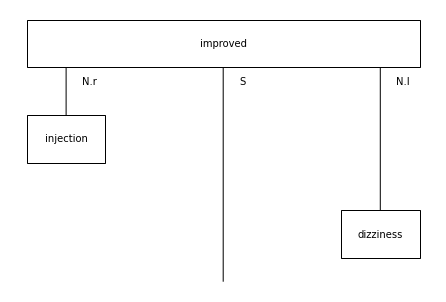

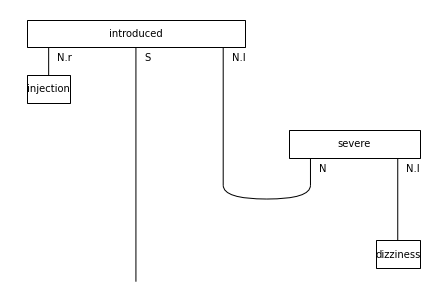

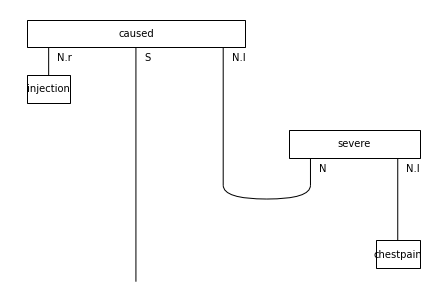

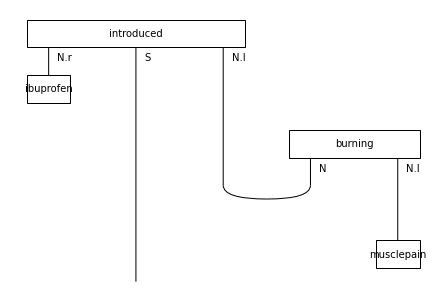

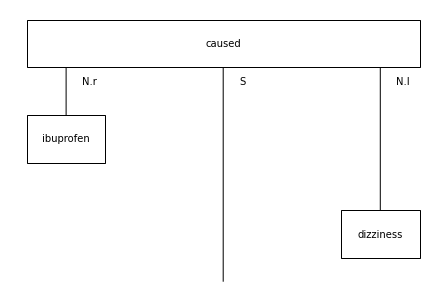

In [11]:
for sentstr in sentence_samples:
    sentences_pg_psr_dic[sentstr].draw()

### 2.2 Quantum Circuit Diagram

In [12]:
ob = {s: q_s, n: q_n}                           # assignment of number of qubits to atomic grammatical types
ob_cqmap = {s: qubit ** q_s, n: qubit ** q_n}   # the form in which it is needed for discopy's cqmap module

Ansatz for encoding sentences into variational circuits

In [13]:
def single_qubit_iqp_ansatz(params):
    if len(params) == 1:
        return Rx(params[0])  
    if len(params) == 2:
        return Rx(params[0]) >> Rz(params[1])
    if len(params) == 3:
        return IQPansatz(1, params)       

def ansatz_state(state, params):  
    arity = sum(ob[Ty(factor.name)] for factor in state.cod)
    if arity == 1:
        return Ket(0) >> single_qubit_iqp_ansatz(params)
    else:
        return Ket(*tuple([0 for i in range(arity)])) >> IQPansatz(arity, params)
    
def ansatz_effect(effect, params):  
    arity = sum(ob[Ty(factor.name)] for factor in effect.dom)
    if arity == 1:
        return single_qubit_iqp_ansatz(params) >> Bra(0)
    else:
        return IQPansatz(arity, params) >> Bra(*tuple([0 for i in range(arity)]))
       
def ansatz(box,params):
    dom_type = box.dom
    cod_type = box.cod
    if len(dom_type) == 0 and len(cod_type) != 0:
        return ansatz_state(box, params)
    if len(dom_type) != 0 and len(cod_type) == 0:
        return ansatz_effect(box, params)

Define parametrised functor to quantum circuits

In [14]:
def F(params): 
    ar = dict()
    for i in range(len(vocab_psr)):
        pgbox = vocab_psr[i]
        qbox = ansatz(vocab_psr[i], params[i])
        ar.update({pgbox: qbox})
        if pgbox.cod == Ty():
            ar.update({Box(pgbox.name, n.l, Ty()): qbox})  # send the effect with n.l to same quantum effect
    return CircuitFunctor(ob_cqmap, ar)

Functions to deal with the parametrisation

In [15]:
def paramshapes(vocab_psr):
    parshapes = []    
    for box in vocab_psr:
        dom_type = box.dom
        cod_type = box.cod
        dom_arity = sum(ob[Ty(factor.name)] for factor in box.dom)
        cod_arity = sum(ob[Ty(factor.name)] for factor in box.cod)
        if dom_arity == 0 or cod_arity == 0:  # states and effects
            arity = max(dom_arity, cod_arity)
            assert arity != 0
            if arity == 1:
                parshapes.append((p_n,))       
            if arity != 1:
                parshapes.append((depth, arity-1))
    return parshapes


def initparams(par_shapes):     #Initial parameters, particularly important since we will be using coordinate
    params = np.array([])       #descent for optimization. We choose pi/2 rotation as starting point for each gate
    for i in range(len(par_shapes)):
        params = np.concatenate((params, np.ravel(0.25*np.ones(par_shapes[i]))))
    return params 


def reshape_params(unshaped_pars, par_shapes):
    pars_reshaped = [[] for ii in range(len(par_shapes))]
    shift = 0
    for ss, s in enumerate(par_shapes):
        idx0 = 0 + shift
        if len(s) == 1:
            idx1 = s[0] + shift
        elif len(s) == 2:
            idx1 = s[0] * s[1] + shift
        pars_reshaped[ss] = np.reshape(unshaped_pars[idx0:idx1], s)
        if len(s) == 1:
            shift += s[0]
        elif len(s) == 2:
            shift += s[0] * s[1]
    return pars_reshaped

Just to know how many parameters we have in our model

In [16]:
par_shapes = paramshapes(vocab_psr)
init_unshaped_pars = initparams(par_shapes)
init_shaped_pars = reshape_params(init_unshaped_pars, par_shapes)
print('Number of parameters:', len(init_unshaped_pars))

Number of parameters: 34


Visualize Quantum Circuits

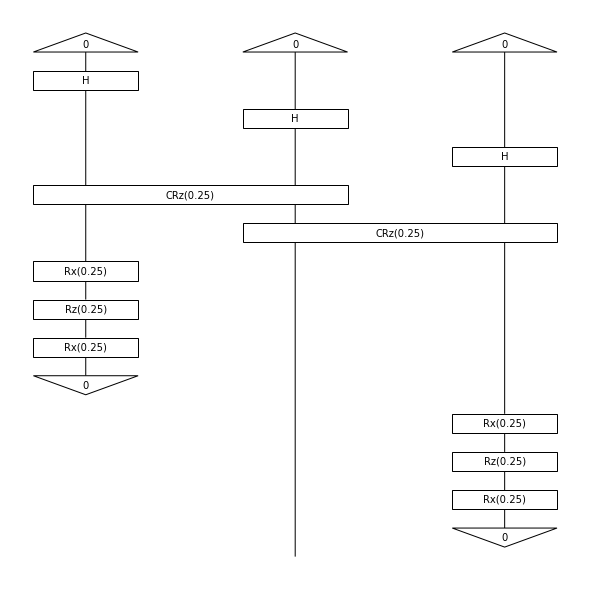

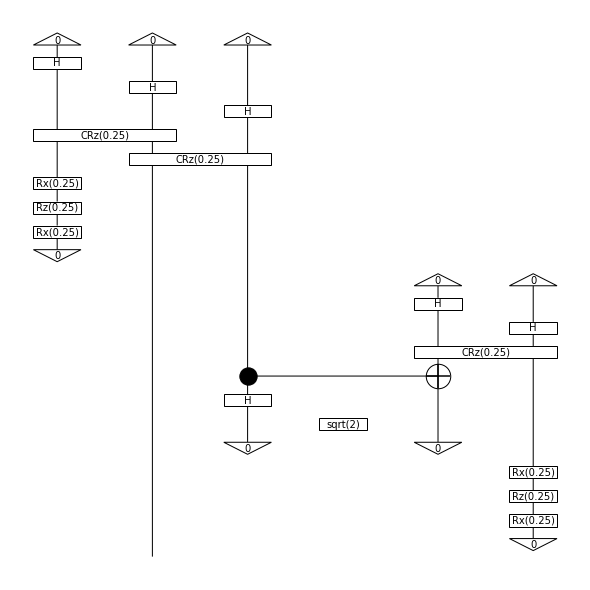

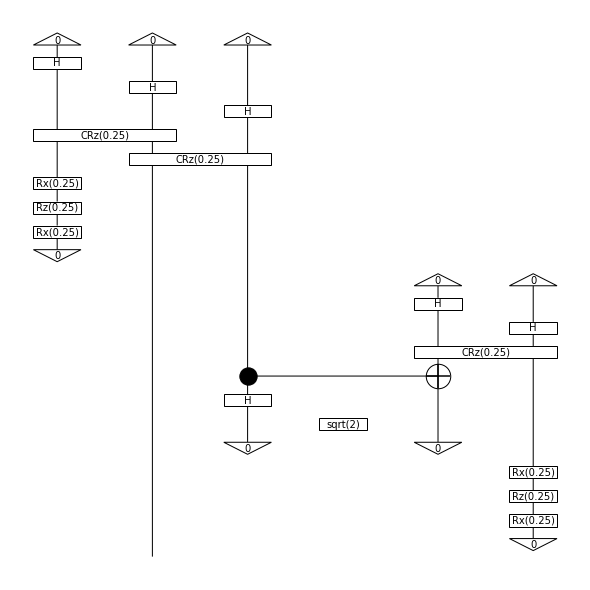

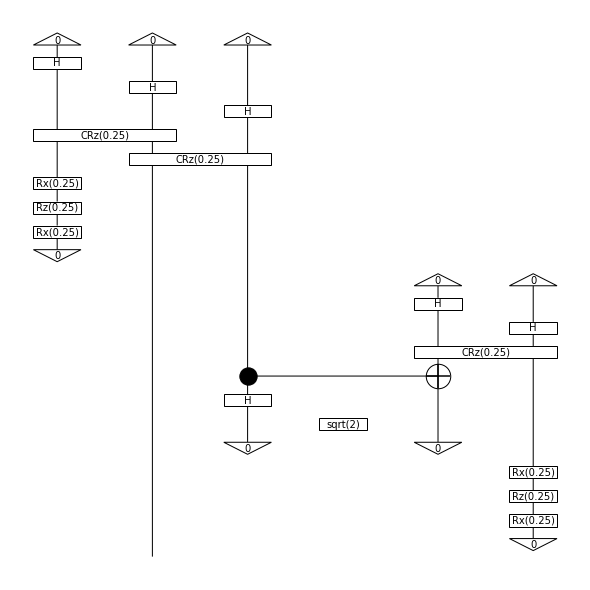

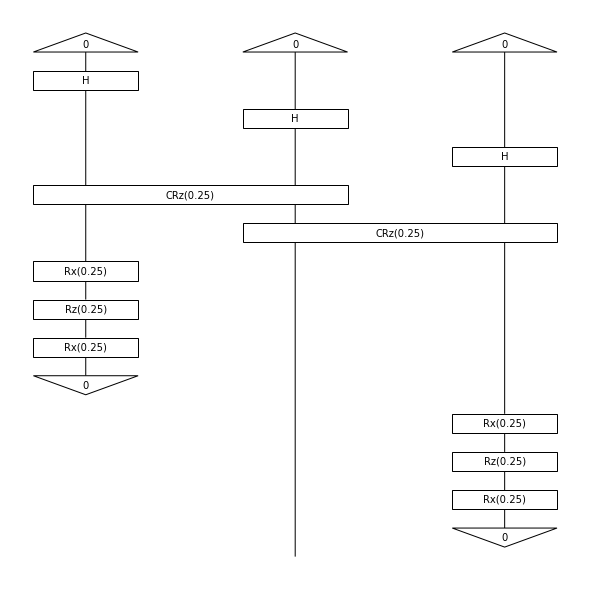

In [17]:
func = F(init_shaped_pars)
for sentstr in sentence_samples:
    func(sentences_pg_psr_dic[sentstr]).draw(draw_box_labels=True, figsize=(8, 8))

## 3. Variational Circuits Stage

### 3.1 Define Cost Functions and Errors

In [18]:
def get_probs(unshaped_params):
    func = F(reshape_params(unshaped_params, par_shapes))
    train_circuits = [(func(circ) >> Measure()) for circ in train_circuits_pg_psr]
    results = DCP_Circuit.eval(*train_circuits, backend=backend, n_shots=n_shots, compilation=backend.default_compilation_pass(2))
    results_tweaked = [np.abs(np.array(res.array) - 1e-9) for res in results]
    pred_labels_distrs = [res / np.sum(res) for res in results_tweaked]
    return pred_labels_distrs

def get_cost(pred_labels_distrs):
    cross_entropies = np.array([np.sum(train_labels[s] * np.log2(pred_labels_distrs[s])) for s in range(len(train_labels))])
    return -1 / len(training_data) * np.sum(cross_entropies)

def get_train_error(pred_labels_distrs):
    error = 0.0
    assert len(pred_labels_distrs[0]) == 2  # rounding only makes sense if labels are binary tuples
    pred_labels = [np.round(res) for res in pred_labels_distrs]
    for i in range(len(pred_labels)):
        if np.sum(pred_labels[i]) != 1.0:  # when equal weights or no counts gives label [1,1] (due to - 1e-9)
            error += 1
        else:
            error += np.abs(train_labels[i][0] - pred_labels[i][0]) # above ensures precited label as [0,1] or [1,0]
    return round(error * 100 / len(training_data), 1)

def get_test_error(unshaped_params):
    func = F(reshape_params(unshaped_params, par_shapes))
    test_circuits = [(func(circ) >> Measure()) for circ in test_circuits_pg_psr]
    results = DCP_Circuit.eval(*test_circuits, backend=backend, n_shots=n_shots, compilation=backend.default_compilation_pass(2))
    results_tweaked = [np.abs(np.array(res.array) - 1e-9) for res in results]
    assert len(results_tweaked[0]) == 2
    pred_labels = [np.round(res / np.sum(res)) for res in results_tweaked]
    error = 0.0
    for i in range(len(pred_labels)):
        if np.sum(pred_labels[i]) != 1.0:
            error += 1
        else:
            error += np.abs(test_labels[i][0] - pred_labels[i][0])
    error = round(error * 100 / len(testing_data), 1)
    return error, pred_labels

### 3.2 Define Optimization Method

In [19]:
#**********************************************************************************
# Minimization algorithm
#**********************************************************************************
def my_psr(get_probs, get_cost, get_train_error, get_test_error, x0,
            bounds=None, niter=100, step_size=0.085,
            print_iter=False, correct_func_value=True,
            filename='minimize_output', iters_selected=[]):
    N = len(x0)
    if bounds is None:
        project = lambda x: x
    else:
        bounds = np.asarray(bounds)
        project = lambda x: np.clip(x, bounds[:, 0], bounds[:, 1])    
    param_history = []
    func_history = []
    error_history = []
    pred_label_history = []
    pred_labels_test_error = dict()
    test_error_list = []
    x = x0    
    
    order = np.arange(N)

    # Loop over iterations
    for k in range(niter):
        if print_iter:
            print('-------------', '\n', 'iteration: ', k, sep='')
        start = time() 
        i,j = k%N, k//N
        if i == 0:
            np.random.shuffle(order) #shuffle the order of coordinates once all get updated once
            
        # determine stepping parameters
        step = np.exp(-j/2)*step_size #change to paramter decreases exponentially with rounds of iteration
        delta_plus = np.zeros(N)
        delta_plus[order[i]] += 1/4
        delta_minus = np.zeros(N)
        delta_minus[order[i]] -= 1/4
        
        # move in + direction from previous x
        xplus = project(x + delta_plus)        
        if print_iter:
            print('Call for xplus')
        results_tweaked_plus = get_probs(xplus)
        funcplus = get_cost(results_tweaked_plus)
        
        # move in - direction from previous x
        xminus = project(x + delta_minus)
        if print_iter:
            print('Call for xminus')
        results_tweaked_minus = get_probs(xminus)
        funcminus = get_cost(results_tweaked_minus)
        
        # new step
        if funcplus > funcminus:
            step *= -1
        x[order[i]]+= step
        x = project(x)
        param_history.append(x)
        
        # determine current func and error
        if correct_func_value or k == (niter - 1):  # In order to save time the cost at x is only evaluated for final step
            if print_iter:
                print('Call for current_func_value')
            results_tweaked = get_probs(x)
            current_func_value = get_cost(results_tweaked)
            error = get_train_error(results_tweaked)
            print(error)
            pred_label_history.append(results_tweaked)
        else:
            current_func_value = funcplus
            error = get_train_error(results_tweaked_plus)
            pred_label_history.append(results_tweaked_plus)
        
        # calculate test error if a 'selected iteration' 
        if k in iters_selected:
            print('Calculate test error for iteration:', k)
            res = get_test_error(x)
            test_error_list.append(res[0])
            pred_labels_test_error.update({k: res[1]})
        
        func_history.append(current_func_value)
        error_history.append(error)

        # save to file
        dump_data = {
            'param_history': param_history,
            'func_history': func_history,
            'error_history': error_history,
            'predlabel_history': pred_label_history,
            'iters_selected': iters_selected,
            'test_error_list': test_error_list,
            'pred_labels_test_error': pred_labels_test_error
        }
        with open(filename+'.pickle', 'wb') as file_handle:
            pickle.dump(dump_data, file_handle)
        
        if print_iter:
            print('Time taken for this iteration: ', time() - start)
    return param_history, func_history, error_history, test_error_list

## 3.3 Run the Algorithm

Encode data such that the circuits (for one call of cost function etc.) can be sent as one job to quantum hardware.

In [20]:
number = 16   # the number appearing in folder name, need to be changed for each experiment

In [21]:
folder_path = "./experiment_results/"
folder_path += 'Data_'+str(number)+'/'   # folder path to later store the experiment results
os.mkdir(folder_path)

In [22]:
train_labels = []
train_circuits_pg_psr = []
for sentstr in training_data:
    train_circuits_pg_psr.append(sentences_pg_psr_dic[sentstr])
    train_labels.append(np.array(data_dic[sentstr]))
train_labels = np.array(train_labels)

test_labels = []
test_circuits_pg_psr = []
for sentstr in testing_data:
    test_circuits_pg_psr.append(sentences_pg_psr_dic[sentstr])
    test_labels.append(np.array(data_dic[sentstr]))
test_labels = np.array(test_labels)

In [23]:
bounds = [[0.0, 1.0] for ii in range(len(init_unshaped_pars))]  
#set the bounds for parameters. angles are defined in unit of 2pi. So bound with [0,1]                 

param_histories = []
cost_histories = np.zeros((n_runs, niter))
error_train_histories = np.zeros((n_runs, niter))

# For test error calculation (for reasons of time cost not for all iterations)
iters_selected = [(i+1)*10-1 for i in range(int(niter/10))]
iters_selected.insert(0, 0)
error_test_histories = np.zeros((n_runs, len(iters_selected)))

for i in range(n_runs):
    print('---------------------------------')
    print('Start run ', i+1)
    init_unshaped_pars = initparams(par_shapes)
    start = time()
    res = my_psr(get_probs, get_cost, get_train_error, get_test_error, init_unshaped_pars,
                  bounds=bounds, niter=niter,
                  print_iter=True, correct_func_value=False, filename=(folder_path + 'experiment_record_' + str(number)),
                  iters_selected=iters_selected)
    param_histories.append(res[0])   
    cost_histories[i, :] = res[1]
    error_train_histories[i, :] = res[2]
    error_test_histories[i, :] = res[3]
    print('run', i+1, 'done')
    print('Time taken: ', time() - start)
print(res[0])

---------------------------------
Start run  1
-------------
iteration: 0
Call for xplus
Call for xminus
Calculate test error for iteration: 0
Time taken for this iteration:  10.366849899291992
-------------
iteration: 1
Call for xplus
Call for xminus
Time taken for this iteration:  6.406919002532959
-------------
iteration: 2
Call for xplus
Call for xminus
Time taken for this iteration:  6.632429838180542
-------------
iteration: 3
Call for xplus
Call for xminus
Time taken for this iteration:  8.361159801483154
-------------
iteration: 4
Call for xplus
Call for xminus
Time taken for this iteration:  15.235162019729614
-------------
iteration: 5
Call for xplus
Call for xminus
Time taken for this iteration:  15.866894006729126
-------------
iteration: 6
Call for xplus
Call for xminus
Time taken for this iteration:  16.21700096130371
-------------
iteration: 7
Call for xplus
Call for xminus
Time taken for this iteration:  15.491161108016968
-------------
iteration: 8
Call for xplus
Call 

Call for xminus
Time taken for this iteration:  5.529991149902344
-------------
iteration: 73
Call for xplus
Call for xminus
Time taken for this iteration:  7.505520820617676
-------------
iteration: 74
Call for xplus
Call for xminus
Time taken for this iteration:  8.273518800735474
-------------
iteration: 75
Call for xplus
Call for xminus
Time taken for this iteration:  7.071118116378784
-------------
iteration: 76
Call for xplus
Call for xminus
Time taken for this iteration:  15.199021100997925
-------------
iteration: 77
Call for xplus
Call for xminus
Time taken for this iteration:  11.12432312965393
-------------
iteration: 78
Call for xplus
Call for xminus
Time taken for this iteration:  6.398077964782715
-------------
iteration: 79
Call for xplus
Call for xminus
Calculate test error for iteration: 79
Time taken for this iteration:  6.7818849086761475
-------------
iteration: 80
Call for xplus
Call for xminus
Time taken for this iteration:  6.809327125549316
-------------
iterati

Call for xminus
Time taken for this iteration:  5.020730972290039
-------------
iteration: 146
Call for xplus
Call for xminus
Time taken for this iteration:  4.963134050369263
-------------
iteration: 147
Call for xplus
Call for xminus
Time taken for this iteration:  4.9782631397247314
-------------
iteration: 148
Call for xplus
Call for xminus
Time taken for this iteration:  5.999737739562988
-------------
iteration: 149
Call for xplus
Call for xminus
Calculate test error for iteration: 149
Time taken for this iteration:  5.738965272903442
-------------
iteration: 150
Call for xplus
Call for xminus
Time taken for this iteration:  5.030606746673584
-------------
iteration: 151
Call for xplus
Call for xminus
Time taken for this iteration:  5.010326862335205
-------------
iteration: 152
Call for xplus
Call for xminus
Time taken for this iteration:  5.007599115371704
-------------
iteration: 153
Call for xplus
Call for xminus
Time taken for this iteration:  4.97114896774292
-------------


## 4 Results

In [24]:
cost_history = cost_histories[0, :]
error_train_history = error_train_histories[0, :]
error_test_history = error_test_histories[0, :]

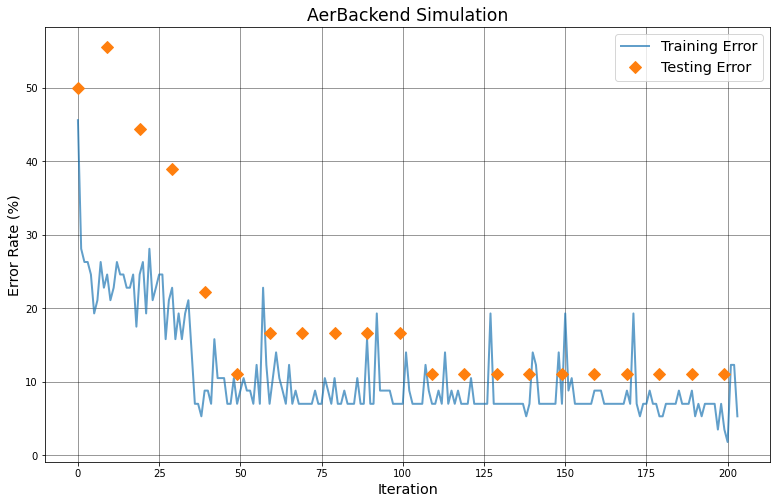

In [25]:
fig, ax1 = plt.subplots(figsize=(13, 8))
ax1.set_xlabel("Iteration", fontsize='x-large', color = 'black')
ax1.set_ylabel("Error Rate (%)", fontsize='x-large', color = 'black')
plt.grid(b=True, which='major', color='black', linestyle='-', alpha=0.5)
ax1.plot(np.arange(len(cost_history)), error_train_history, linewidth = 2, alpha=0.7, label='Training Error')
ax1.plot(iters_selected, error_test_history, 'D', markersize=8, label='Testing Error')
ax1.legend(loc='upper right', fontsize='x-large')

plt.title('AerBackend Simulation', fontsize='xx-large', color = 'black')
plt.savefig(folder_path+'result_plot_'+str(number)+'.png')  
plt.show()

In [26]:
with open(folder_path + 'experiment_record_' + str(number) +'.pickle', 'rb') as f:
    results = pickle.load(f)
params = results['param_history'][-1]
params = np.expand_dims(params, 1)

par_shapes = paramshapes(vocab_psr)
shaped_pars = reshape_params(params, par_shapes)


def evaluate(params, sentences, backend, n_shots=2**10, seed=0):
    for sentstr in sentences_pg_psr_dict:
        circuits = func(sentences_pg_psr_dict[sentstr])
        results = [DCP_Circuit.eval(
                    circuit,
                    backend=backend,
                    n_shots=n_shots,
                    seed=seed,
                    compilation=backend.default_compilation_pass(2)) for circuit in circuits]
        tensors = [np.abs(result.array)[0] for result in results]
    return tensors

delta = .01

In [27]:
param_name = folder_path+"param_"+str(number)+".txt"
train_name = folder_path+"train_"+str(number)+".txt"
test_name = folder_path+"test_"+str(number)+".txt"

pa = open(param_name,"w+")
for i in range(134):
    pa.write('iteration '+str(i)+'\n')
    for param in results['param_history']:
        pa.write(str(param)+'\n')
pa.close()

tr = open(train_name,"w+")
for error in error_train_history:
    tr.write(str(error)+'\n')
tr.close()

te = open(test_name,"w+")
for error in error_test_history:
    te.write(str(error)+'\n')
te.close()

In [28]:
with open(folder_path + 'experiment_record_' + str(number)+'.pickle', 'rb') as f:
    results = pickle.load(f)
params = results['param_history'][-1]
params = np.expand_dims(params, 1)

#check out test set
error, pred_labels = get_test_error(params)
for i in range(0, 10): 
    print(testing_data[i])
    if (pred_labels[i][0] == 0. ):
        print('not AD')
    else:
        print('AD')
    print('######################################################')

injection improved dizziness
not AD
######################################################
injection introduced severe dizziness
AD
######################################################
injection caused severe chestpain
AD
######################################################
ibuprofen introduced burning musclepain
AD
######################################################
ibuprofen caused dizziness
AD
######################################################
ibuprofen caused bloating
AD
######################################################
injection worsened bloating
AD
######################################################
injection solved dizziness
not AD
######################################################
injection improved bloating
not AD
######################################################
injection improved chestpain
not AD
######################################################


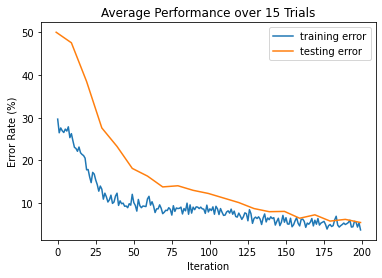

In [36]:
folder_path = "./experiment_results/"
train_error = np.zeros(204)
for i in range(1,16):
    train_name = folder_path+"Data_"+str(i)+"/"+"train_"+str(i)+".txt"
    tr = open(train_name,"r")
    raw_train = tr.readlines()
    train_error_new = np.add(train_error, np.array([int(number[:-3]) for number in raw_train]))
    train_error = train_error_new
    tr.close()
test_error = np.zeros(21)
for i in range(1,16):
    test_name = folder_path+"Data_"+str(i)+"/"+"test_"+str(i)+".txt"
    te = open(test_name,"r")
    raw_test = te.readlines()
    test_error_new = np.add(test_error, np.array([int(number[:-3]) for number in raw_test]))
    test_error = test_error_new
    te.close()
train_error /= 15
test_error /= 15
plt.plot(np.arange(200),train_error[:200], label ="training error")
plt.plot(np.array([i*10-1 for i in range(21)]), test_error, label="testing error")
plt.title('Average Performance over 15 Trials')
plt.xlabel('Iteration')
plt.ylabel('Error Rate (%)')
plt.legend()
plt.savefig(folder_path+'Average_Performance.png')  
plt.show()